# Hopfield Network

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import zipfile

## Data
Data download and decompression

In [2]:
!curl https://frasca.di.unimi.it/MLDNN/input_data.zip -O data.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
 95 4581k   95 4382k    0     0  1718k      0  0:00:02  0:00:02 --:--:-- 1719k
100 4581k  100 4581k    0     0  1770k      0  0:00:02  0:00:02 --:--:-- 1771k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0curl: (6) Could not resolve host: data.zip


In [3]:
with zipfile.ZipFile("input_data.zip", 'r') as zip_ref:
     zip_ref.extractall("unzipped_data")
import pickle as pk
import numpy as np

with open("unzipped_data/input_data.pkl", "rb") as f:
     data_dict = pk.load(f)

Storing

In [4]:
W = data_dict['similarity_matrix']
labels = data_dict['labels']
true_labels = data_dict['true_labels']

## Hopfield Network Model
For our task, the most appropriate model is an Hopfield Network, since we can use its minimization of the energy function to construct a pattern where similar nodes will have the same label. 
We are using the Hopfield Network as a Local Optimizator.

It is a suitable choice as our labels (targets) are in {-1, 1} which is perfect for our Hopfield Network.

The network optimization algorithm will reiterate until it will reach an equilibruim state, which corresponds to the reach of a minimum of the energy function. This minimum will be reached once all unlabelled nodes will have a label and similar nodes will have the same one.

In [5]:
import numpy as np
# Hopfield network as local optimizer
class HopfieldNetworkLO:
    def __init__(self, weight_matrix):
        """Initialize network with a given weight matrix."""
        self.W = np.array(weight_matrix)  # Convert weight matrix to numpy array
        self.N = self.W.shape[0]  # Number of neurons

    def run_dynamics(self, labels, max_iterations=100):
        """Perform asynchronous updates for neurons labeled as '0'."""
        state = np.array(labels, dtype=float)  # Convert labels to float array
        free_neurons = np.where(state == 0)[0]  # Indices of neurons to update
        fixed_neurons = np.where(state != 0)[0]  # Indices of fixed neurons

        # Compute external influence from fixed neurons
        b = np.dot(self.W[:, fixed_neurons], state[fixed_neurons])  # Activation threshold

        for _ in range(max_iterations):
            updated = False
            for i in free_neurons:
                # Compute total input sum (including fixed neurons' influence)
                activation = np.dot(self.W[i], state) - b[i]
                new_state = 1 if activation > 0 else -1

                if new_state != state[i]:
                    state[i] = new_state
                    updated = True

            if not updated:  # Stop if no changes occur
                break

        return state

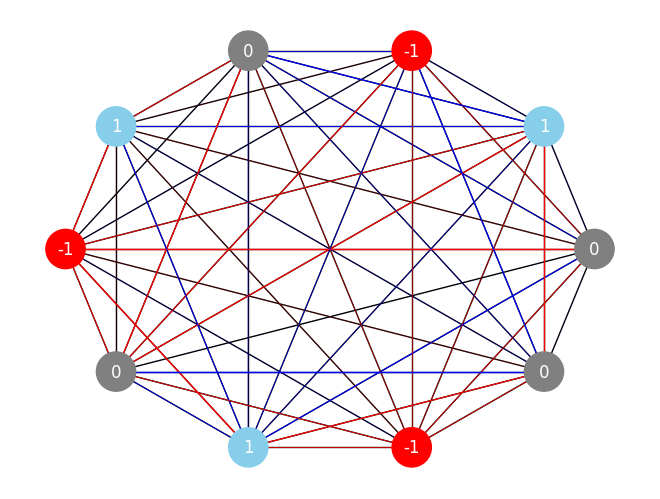

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Numero nodi
N = 10  

# Etichette dei nodi (esempio con stati Hopfield: -1, 0, 1)
ex_labels = {i: str(v) for i, v in enumerate([0, 1, -1, 0, 1, -1, 0, 1, -1, 0])}
ex_colors = ["gray" if v == 0 else "skyblue" if v == 1 else "red" for v in [0, 1, -1, 0, 1, -1, 0, 1, -1, 0]]

# Crea grafo fully connected
G = nx.complete_graph(N)

# Assegna pesi casuali (o calcolati con Hebbian rule)
for (i, j) in G.edges():
    G[i][j]['weight'] = np.random.uniform(-1, 1)  # pesi reali

# Ottieni i pesi
weights = [G[i][j]['weight'] for i, j in G.edges()]

# Normalizza per colori (rosso = negativo, blu = positivo)
edge_colors = ['red' if w < 0 else 'blue' for w in weights]
edge_widths = [abs(w)*1 for w in weights]  # spessore proporzionale al peso

# Layout dei nodi
pos = nx.circular_layout(G)

# Disegna
nx.draw(G, pos, 
        with_labels=True, 
        labels=ex_labels, 
        node_color=ex_colors, 
        node_size=800, 
        font_color="white")

nx.draw_networkx_edges(G, pos, 
                       edge_color=edge_colors, 
                       width=edge_widths)

plt.show()


# Data Handilng
Each author will be represented by a node, which value is going to be its label (labels), while the edges will be represented by the author similarity matrix (W).
This method will result in a fully connected network with n=5000 nodes, there could be some kind of non-existing nodes as their weight might be 0.
The node labels with a value different from 0 aren't going 

Other than the initial state the network doesn't need any other input to work.

In [8]:
outcome = HopfieldNetworkLO(W).run_dynamics(labels)

In [9]:
# Calcolo dell'accuratezza della Hopfield Network
accuracy = np.mean(outcome == true_labels)
print(f"Accuratezza: {accuracy * 100:.2f}%")
score = f1_score(outcome, true_labels)
print(f'F1 score = {score}')

Accuratezza: 93.30%
F1 score = 0.9189842805320435


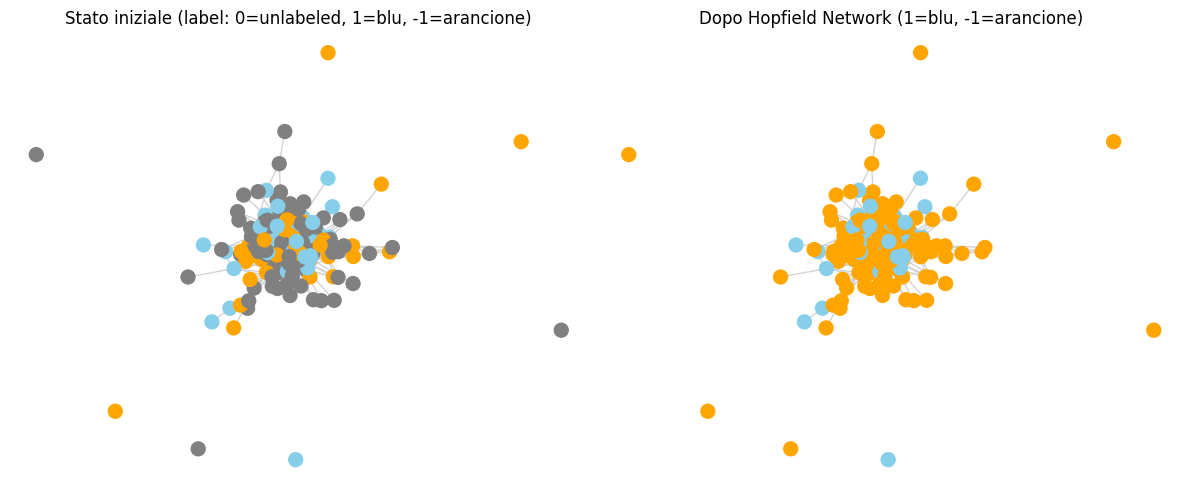

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)
indices = np.arange(len(labels))
selected = np.sort(indices)
# Sottografo con tutti i nodi
W_sub = W[np.ix_(selected, selected)]
labels_sub = labels[selected]
outcome_sub = outcome[selected]
G = nx.from_numpy_array(W_sub)
pos = nx.spring_layout(G, seed=42)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
# Plot iniziale
node_colors_init = ['gray' if l==0 else ('skyblue' if l==1 else 'orange') for l in labels_sub]
nx.draw(G, pos, ax=axs[0], with_labels=False, node_color=node_colors_init, edge_color='lightgray', node_size=100)
axs[0].set_title('Stato iniziale (label: 0=unlabeled, 1=blu, -1=arancione)')
# Plot dopo Hopfield: colore in base alla nuova label
node_colors_out = [('skyblue' if outcome_sub[i]==1 else ('orange' if outcome_sub[i]==-1 else 'gray')) for i in range(len(selected))]
nx.draw(G, pos, ax=axs[1], with_labels=False, node_color=node_colors_out, edge_color='lightgray', node_size=100)
axs[1].set_title('Dopo Hopfield Network (1=blu, -1=arancione)')
plt.tight_layout()
plt.show()